간단한 예시로 비틀즈의 노래를 이용해 화음 인식 절차를 확인해보고, 결과를 해석해본다.

> 이 글은 [FMP(Fundamentals of Music Processing) Notebooks](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html)을 참고로 합니다.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa

from utils.plot_tools import *
from utils.feature_tools import smooth_downsample_feature_sequence, median_downsample_feature_sequence
from utils.structure_tools import read_structure_annotation
from utils.chord_tools import get_chord_labels, compute_chromagram_from_filename, compute_eval_measures, \
convert_chord_ann_matrix, chord_recognition_template
from utils.chord_tools import viterbi_log_likelihood, plot_matrix_chord_eval, uniform_transition_matrix

**실험: 비틀즈 컬렉션**

# 오디오 데이터, 주석

- 12개의 비틀즈 앨범 (180트랙)의 컬렉션
- 고품질의 참조 주석
    - 화음, 비트, 음조 변화, 음악 구조
    - 출처: [Christopher Harte's PhD thesis (2010)] <a href="http://isophonics.net/content/reference-annotations-beatles">Isophonics Website</a>
    - 단 여기서는 24개의 화음 유형으로 축소

In [2]:
# Read annotation files
fn_ann_orig = '../data_FMP/FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords.csv'
fn_ann = '../data_FMP/FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv'
ann_orig, _ = read_structure_annotation(fn_ann_orig)
ann, _ = read_structure_annotation(fn_ann)

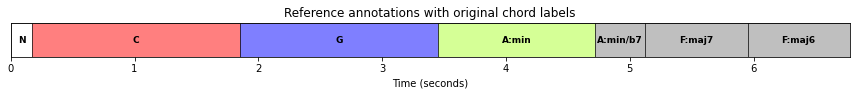

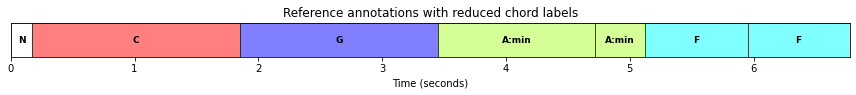

In [3]:
# Plot chord annotations
color_ann = {'N': 'white', 
             'C': 'red', 'C#': 'peru', 'D': 'orange', 'D#': 'yellow', 'Eb': 'yellow', 
             'E': 'springgreen', 'F': 'cyan', 'F#': 'coral', 'G': 'blue', 
             'G#': 'olive', 'A': 'teal', 'A#': 'indigo', 'Bb': 'indigo', 'B': 'pink',
             'C#:min': 'steelblue', 'C#m': 'steelblue', 'A:min': 'greenyellow', 'A:m': 'greenyellow',
             'G:min': 'olive', 'E:min': 'lightcoral', 'B:min': 'saddlebrown'}
chord_labels = get_chord_labels(ext_minor='m', nonchord=False)

plot_segments(ann_orig[:7], figsize=(12, 1.2), time_label='Time (seconds)', 
                        fontsize=9, colors=color_ann, alpha=0.5)
plt.title('Reference annotations with original chord labels')
plt.show()
plot_segments(ann[:7], figsize=(12, 1.2), time_label='Time (seconds)', 
                       fontsize=9, colors=color_ann, alpha=0.5)
plt.title('Reference annotations with reduced chord labels')
plt.show()

- 여기서는 4개의 노래만 예시로 보기로 한다. 무음이나 박수 소리같은 비음악적인 부분이 적은 노래들이다. 

In [4]:
fn_wav1 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06.wav"
fn_wav2 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav"
fn_wav3 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav"
fn_wav4 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav"

fn_ann1 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv"
fn_ann2 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv"
fn_ann3 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv"
fn_ann4 = "../data_FMP/Beatles_Collection/FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv"

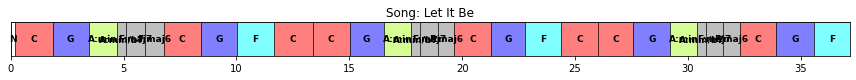

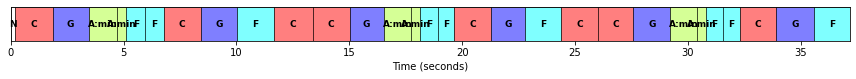

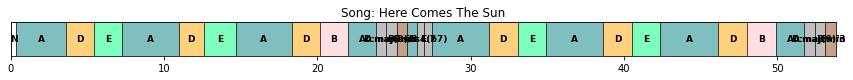

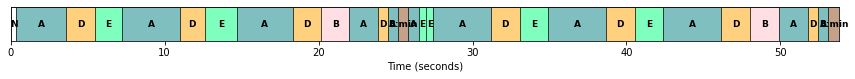

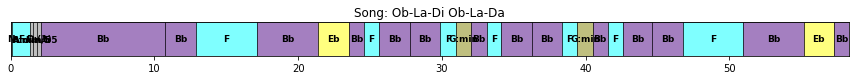

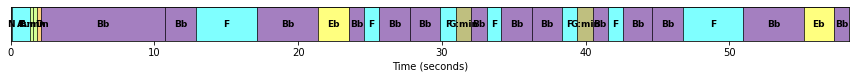

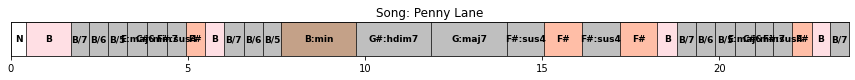

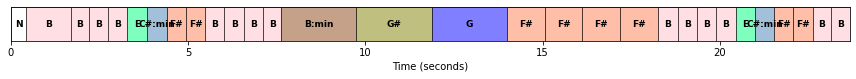

In [5]:
song_dict = {} # song name, color, wav filename, annotation filename
song_dict[0] = ['Let It Be', 'r', fn_wav1, fn_ann1]
song_dict[1] = ['Here Comes The Sun', 'b', fn_wav2, fn_ann2]
song_dict[2] = ['Ob-La-Di Ob-La-Da', 'c', fn_wav3, fn_ann3]
song_dict[3] = ['Penny Lane', 'g', fn_wav4, fn_ann4]

chord_labels = get_chord_labels(ext_minor='m', nonchord=False)
song_selected = [0, 1, 2, 3]

for s in song_selected:
    song_id = song_dict[s][0]
    fn_ann = song_dict[s][3]
    fn_ann_orig = fn_ann.replace('_simplified','')

    ann_orig, _ = read_structure_annotation(fn_ann_orig)
    ann, _ = read_structure_annotation(fn_ann)

    plot_segments(ann_orig[:30], figsize=(12, 1), 
                           fontsize=9, colors=color_ann, alpha=0.5)
    plt.title('Song: %s' % song_id)
    plt.show()
    plot_segments(ann[:30], figsize=(12, 1.2), time_label='Time (seconds)', 
                           fontsize=9, colors=color_ann, alpha=0.5)
    plt.show()

# 특징 추출 (Feature Extraction)

- 전통적인 화음 인식 접근 방식의 첫 번째 단계는 오디오 녹음을 크로마(chroma) 기반 오디오 특징(feature)의 시퀀스로 변환하는 것이다. 
- 이러한 특징은 적절한 스무딩(smoothing) 필터를 적용하여 시간적(temporal) 이상값을 고르게 하거나, 로그 압축(logarithmic compression)을 적용하여 작지만 지각적으로 관련된 스펙트럼 구성 요소(spectral components)를 향상시키는 등 추가로 처리될 수 있다.


- 사용된 크로마 유형은 [Jiang et al.](https://secure.aes.org/forum/pubs/conferences/?elib=15943)에 의해 입증된 것처럼, 화음 인식 결과에 큰 영향을 미칠 수 있다.
- `librosa`에서 제공하는 세 가지 다른 크로마 유형을 고려하여 이 사실을 설명한다.
     * 작은 로그 압축을 사용하는 STFT 기반 크로마 특징(`librosa.feature.chroma_stft`)
     * CQT 기반 크로마 특징(`librosa.feature.chroma_cqt`)
     * 로그 압축을 사용한 IIR 기반 크로마 특징(`librosa.iirt` + 크로마 비닝(binning))

- 오디오 녹음은 $F_\mathrm{s}=22050~\mathrm{Hz}$의 rate으로 샘플링된다.
     - STFT 계산을 위해서는 $N=2048$ 샘플($92.9~\mathrm{ms}$에 해당)의 윈도우(window) 크기와 $H=1024$ 샘플($46.4~\mathrm{ms}$에 해당)의 홉 크기를 사용한다. 이는 $21.5~\mathrm{Hz}$의 feature rate으로 이어진다.
     - 또한 IIR 기반 주파수 표현을 계산하기 위해 동일한 매개변수 $N$ 및 $H$를 사용한다.
     - 마지막으로 CQT의 경우 동일한 홉 크기 $H=1024$를 사용하여 동일한 feature rate의 크로마 표현을 생성한다.


- 모든 크로마 특징은 유클리드 norm에 따라 정규화된다. 또한 크로마 시퀀스와 일치하도록 화음 주석을 프레임-수준 라벨 시퀀스로 변환한다.

In [6]:
def compute_X_dict(song_selected, version='STFT', details=True):
    X_dict = {}
    Fs_X_dict = {}
    ann_dict = {}
    x_dur_dict = {}
    chord_labels = get_chord_labels(ext_minor='m', nonchord=False)
    for s in song_selected:
        if details is True:
            print('Processing: ', song_dict[s][0])
        fn_wav = song_dict[s][2]
        fn_ann = song_dict[s][3]
        N = 2048
        H = 1024
        if version == 'STFT':
            X, Fs_X, x, Fs, x_dur = \
                compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
        if version == 'CQT':
            X, Fs_X, x, Fs, x_dur = \
                compute_chromagram_from_filename(fn_wav, H=H, version='CQT')
        if version == 'IIR':
            X, Fs_X, x, Fs, x_dur = \
                compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=10, version='IIR')
        X_dict[s] = X
        Fs_X_dict[s] = Fs_X
        x_dur_dict[s] = x_dur
        N_X = X.shape[1]
        ann_dict[s] = convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)
    return X_dict, Fs_X_dict, ann_dict, x_dur_dict, chord_labels

In [7]:
song_selected = [0, 1, 2, 3]

print('===== Computation of STFT-based chromagrams =====')
X_dict_STFT, Fs_X_dict_STFT, ann_dict_STFT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='STFT')
print('===== Computation of CQT-based chromagrams =====')
X_dict_CQT, Fs_X_dict_CQT, ann_dict_CQT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='CQT')
print('===== Computation of IIR-based chromagrams =====')
X_dict_IIR, Fs_X_dict_IIR, ann_dict_IIR, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='IIR')
print()

===== Computation of STFT-based chromagrams =====
Processing:  Let It Be
Processing:  Here Comes The Sun
Processing:  Ob-La-Di Ob-La-Da
Processing:  Penny Lane
===== Computation of CQT-based chromagrams =====
Processing:  Let It Be
Processing:  Here Comes The Sun
Processing:  Ob-La-Di Ob-La-Da
Processing:  Penny Lane
===== Computation of IIR-based chromagrams =====
Processing:  Let It Be
Processing:  Here Comes The Sun
Processing:  Ob-La-Di Ob-La-Da
Processing:  Penny Lane



맨 앞 15초만 보자.

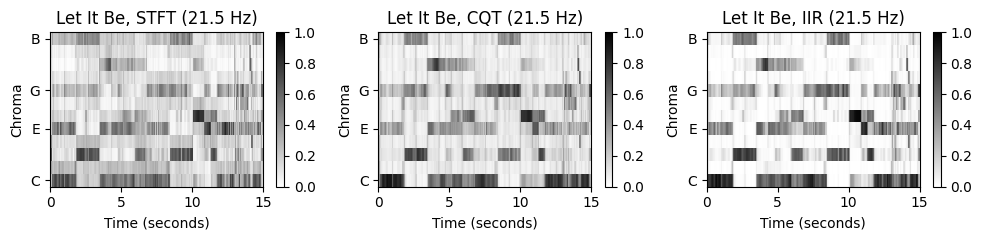

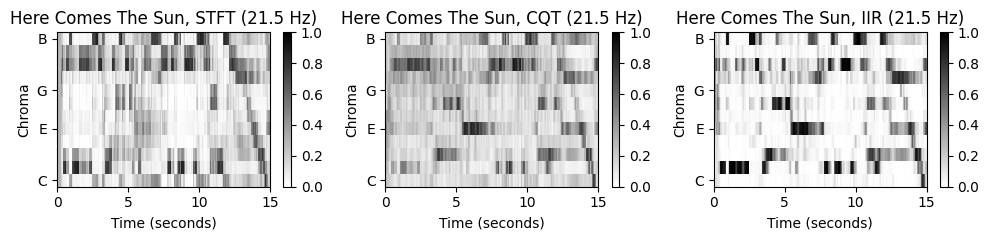

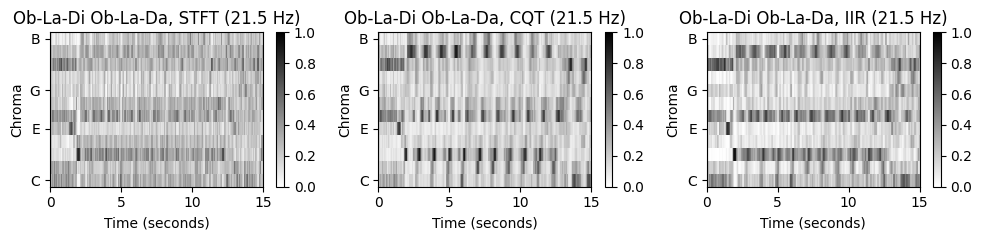

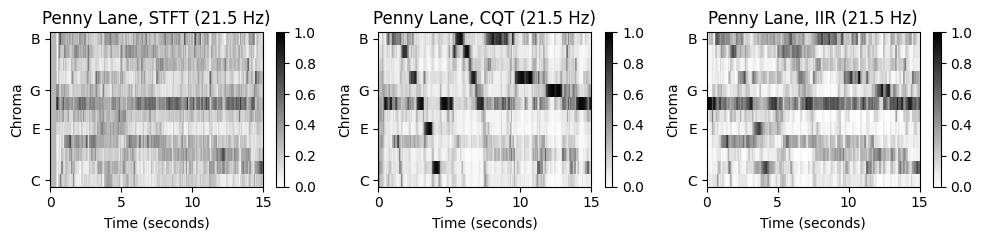

In [8]:
cmap = 'gray_r'
for s in song_selected:
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1], 
                                              'height_ratios': [2]}, figsize=(10, 2.5))
    title = '%s, STFT (%0.1f Hz)' % (song_dict[s][0], Fs_X_dict_STFT[s])
    plot_chromagram(X_dict_STFT[s], Fs=Fs_X_dict_CQT[s], ax=[ax[0]],  
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True, xlim=[0, 15])
    
    title = '%s, CQT (%0.1f Hz)' % (song_dict[s][0], Fs_X_dict_CQT[s])
    plot_chromagram(X_dict_CQT[s], Fs=Fs_X_dict_CQT[s], ax=[ax[1]],  
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True, xlim=[0, 15])  

    title = '%s, IIR (%0.1f Hz)' % (song_dict[s][0], Fs_X_dict_IIR[s])
    plot_chromagram(X_dict_IIR[s], Fs=Fs_X_dict_IIR[s], ax=[ax[2]],  
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True, xlim=[0, 15])      
    plt.tight_layout()   

- "Let It Be"의 경우 세 크로마그램이 비슷하지만, 나머지 노래들은 꼭 그렇지 않다. 특히 "Penny Lane"은 STFT기반 크로마그램에서 동질적인 모습($\mathrm{F}$ 크로마 밴드)을 보이지만, 나머지 특히 CQT기반 크로마그램에서는 하향하는 지배 패턴을 보인다.

- 노래를 들어보면 베이스 기타가 연주하는 저주파수(low-frequency)의 강한 베이스라인이 있다. **STFT의 선형 주파수 분해능**(linear frequency resolution)에 기반하면 저주파수의 정보가 잘 포착되지 않는다. 결과적으로 크로마그램을 얻기 위해 로그 비닝(logarithmic binning)을 적용하면 이러한 정보들을 잃게 된다(서로 다른 피치 밴드를 오염시킴). 

- 반면에 CQT는 frequency-dependent한 윈도우 크기를 사용하여 신호를 **로그 주파수 해상도**(logarithmic frequency resolution)으로 시간-주파수 표현으로 분해한다. 결과적으로 저주파수 음이 STFT보다 훨씬 높은 스펙트럼 해상도로 포착된다.

# 화음 인식 절차 (Chord Recognition Procedures)

- 세 새긩 크로마그램 표현에 기반하여, 크로마 특징을 24 장단화음 라벨로 매핑하는 두 가지의 패턴 매칭 기술을 적용한다.
    * 템플릿 기반 화음 인식 (Template-based chord recognition)
    * HMM 기반 화음 인식 (HMM-based chord recognition)

- **시간-화음**(time-chord) 시각화를 통해 결과를 보자. 우선 "Let It Be"의 6가지 조합(3개의 크로마그램, 2개의 화음 인식)을 본다.

In [9]:
def chord_recognition_all(X, ann_matrix, p=0.15, filt_len=None, filt_type='mean'):
    """Conduct template- and HMM-based chord recognition and evaluates the approaches

    Args:
        X (np.ndarray): Chromagram
        ann_matrix (np.ndarray): Reference annotation as given as time-chord binary matrix
        p (float): Self-transition probability used for HMM (Default value = 0.15)
        filt_len (int): Filter length used for prefilitering (Default value = None)
        filt_type (str): Filter type used for prefilitering (Default value = 'mean')

    Returns:
        result_Tem (tuple): Chord recogntion evaluation results ([P, R, F, TP, FP, FN]) for template-based approach
        result_HMM (tuple): Chord recogntion evaluation results ([P, R, F, TP, FP, FN]) for HMM-based approach
        chord_Tem (np.ndarray): Template-based chord recogntion result given as binary matrix
        chord_HMM (np.ndarray): HMM-based chord recogntion result given as binary matrix
        chord_sim (np.ndarray): Chord similarity matrix
    """
    if filt_len is not None:
        if filt_type == 'mean':
            X, Fs_X = smooth_downsample_feature_sequence(X, Fs=1, filt_len=filt_len, down_sampling=1)
        if filt_type == 'median':
            X, Fs_X = median_downsample_feature_sequence(X, Fs=1, filt_len=filt_len, down_sampling=1)
    # Template-based chord recogntion
    chord_sim, chord_Tem = chord_recognition_template(X, norm_sim='1')
    result_Tem = compute_eval_measures(ann_matrix, chord_Tem)
    # HMM-based chord recogntion
    A = uniform_transition_matrix(p=p)
    C = 1 / 24 * np.ones((1, 24))
    B_O = chord_sim
    chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)
    result_HMM = compute_eval_measures(ann_matrix, chord_HMM)
    return result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim
  
    
def plot_chord_recognition_result(ann_matrix, result, chord_matrix, chord_labels,
                                  xlim=None, Fs_X=1, title='', figsize=(12, 4)):
    P, R, F, TP, FP, FN = result
    method='HMM' 
    title = title + ' (TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (TP, FP, FN, P, R, F)
    fig, ax, im = plot_matrix_chord_eval(ann_matrix, chord_matrix, Fs=Fs_X, figsize=figsize,
                         title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)
    if xlim is not None:
        plt.xlim(xlim)
    plt.tight_layout()
    plt.show()

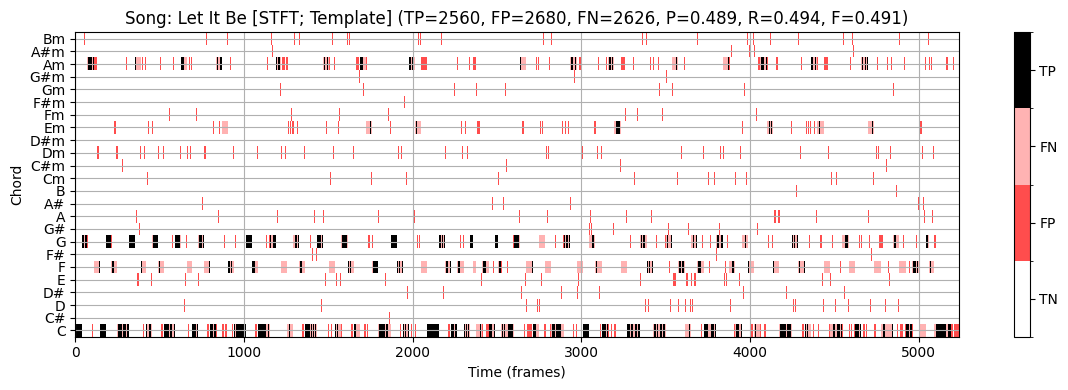

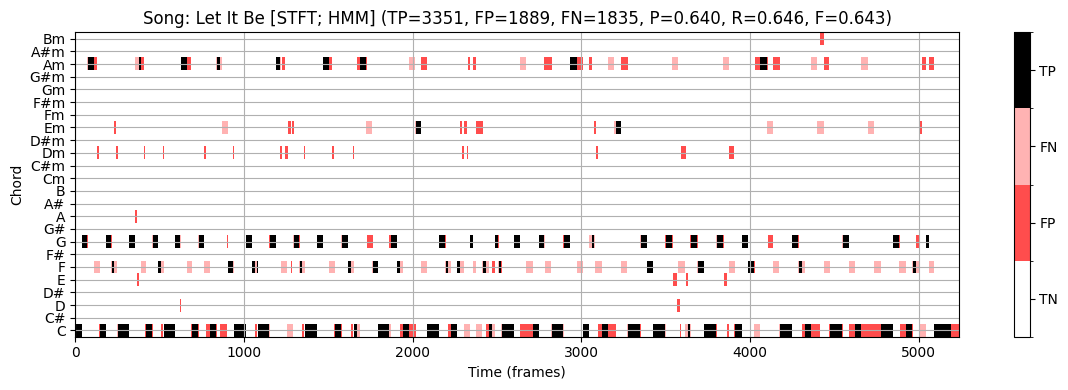

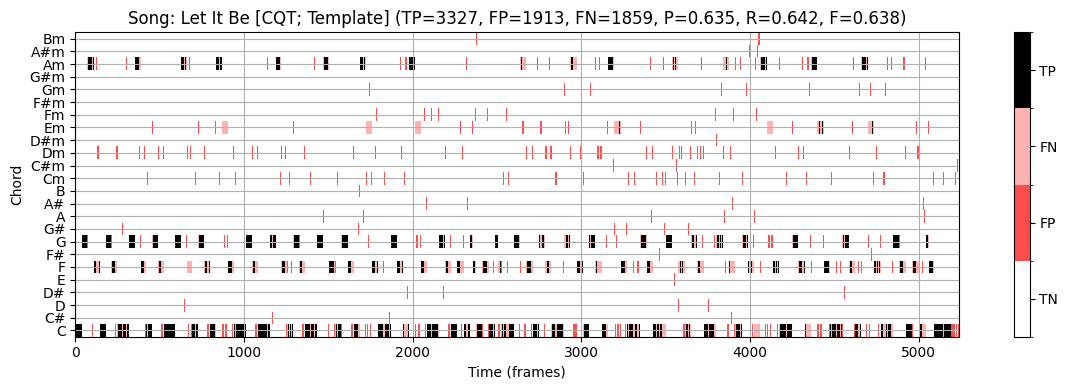

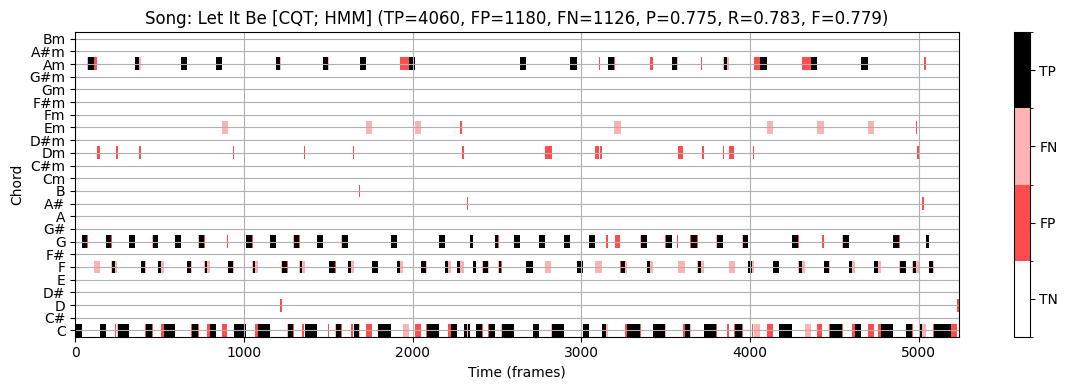

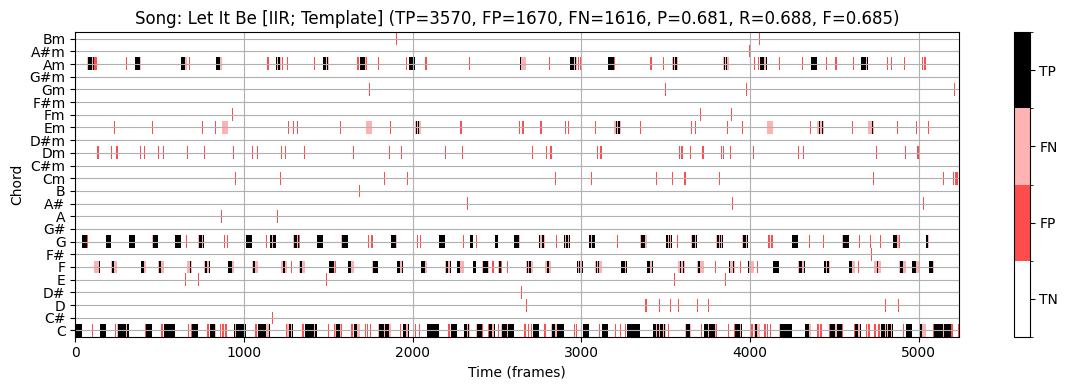

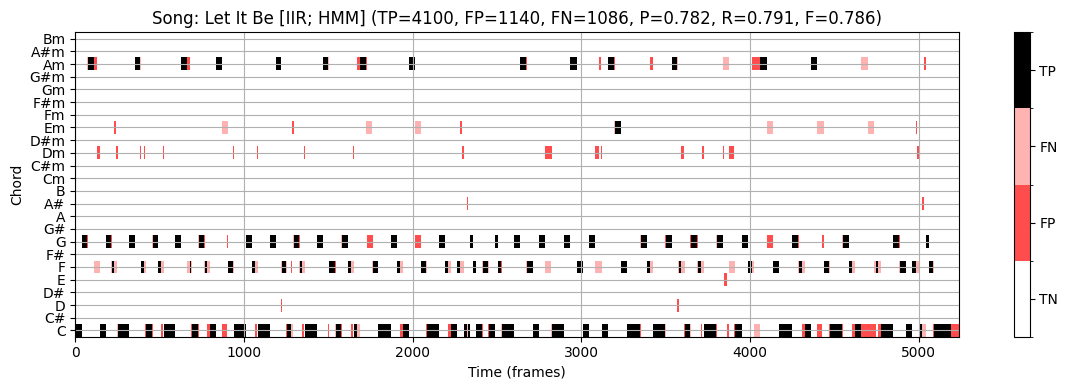

In [10]:
song_selected = [0] # 렛잇비

for s in song_selected:
    output = chord_recognition_all(X_dict_STFT[s], ann_dict_STFT[s][0], p=0.15)
    result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim = output
    title = 'Song: %s [STFT; Template]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_STFT[s][0], result_Tem, chord_Tem, chord_labels, title=title)
    title = 'Song: %s [STFT; HMM]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_STFT[s][0], result_HMM, chord_HMM, chord_labels, title=title)

    output = chord_recognition_all(X_dict_CQT[s], ann_dict_CQT[s][0], p=0.15)
    result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim = output
    title = 'Song: %s [CQT; Template]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_CQT[s][0], result_Tem, chord_Tem, chord_labels, title=title)
    title = 'Song: %s [CQT; HMM]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_STFT[s][0], result_HMM, chord_HMM, chord_labels, title=title)
    
    output = chord_recognition_all(X_dict_IIR[s], ann_dict_IIR[s][0], p=0.15)
    result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim = output
    title = 'Song: %s [IIR; Template]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_STFT[s][0], result_Tem, chord_Tem, chord_labels, title=title)
    title = 'Song: %s [IIR; HMM]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_IIR[s][0], result_HMM, chord_HMM, chord_labels, title=title)    

- STFT 기반 크로마그램과 템플렛 기반 화음 인식을 사용하면 F-스코어 $\mathrm{F}=0.491$을 얻는다. 
    - 화음 라벨 사이의 갑작스런 점프들이 있는 것을 볼 수 있다.
    
- HMM 기반 방식을 사용하면 이상치를 줄여 F-스코어를 올린다. ($\mathrm{F}=0.643$)

- CQT 기반 크로마그램을 input으로 하면 결과는 상당히 개선된다. ($\mathrm{F}=0.779$)

- 가장 좋은 결과는 "IIR 기반 크로마그램 + HMM 기반 화음 인식" 이다. ($\mathrm{F}=0.789$)

- 이제 CQT크로마그램 + HMM 화음 인식 을 사용해 네 노래의 인식 결과를 보자.

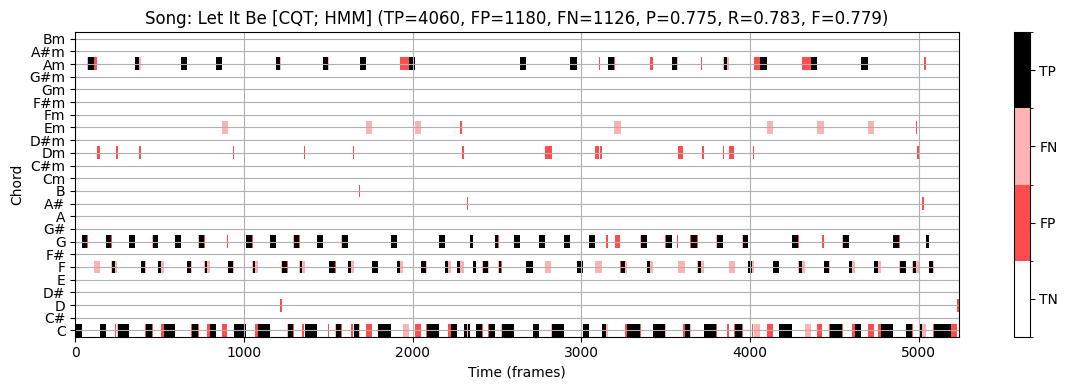

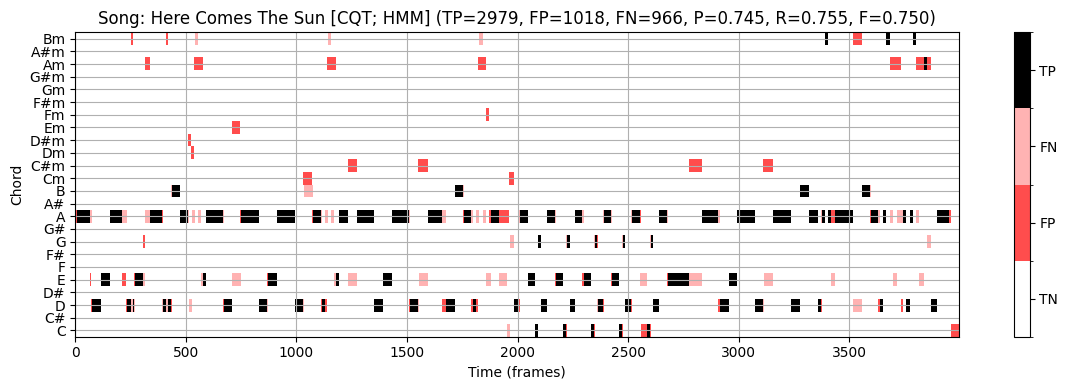

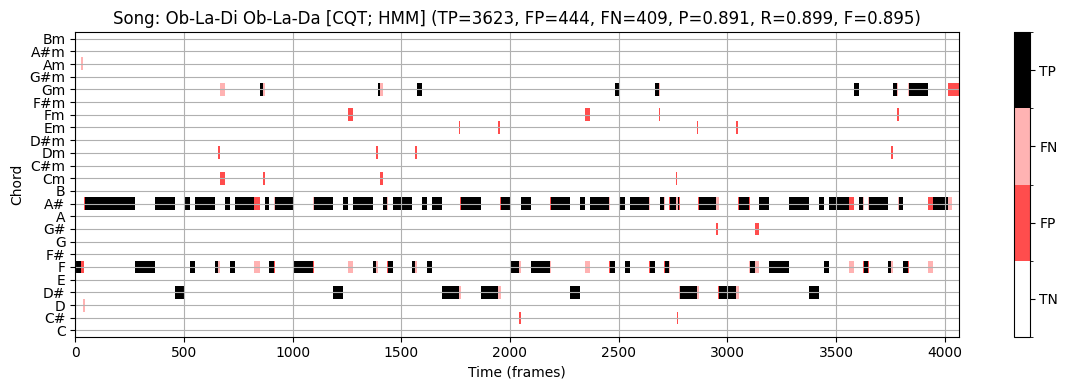

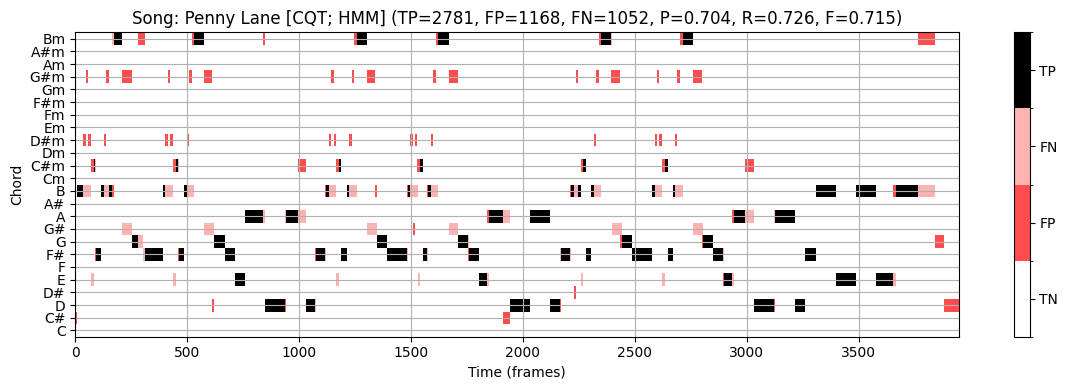

In [11]:
# 전체

song_selected = [0, 1, 2, 3]
for s in song_selected:
    output = chord_recognition_all(X_dict_CQT[s], ann_dict_CQT[s][0], p=0.15)
    result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim = output
    title='Song: %s [CQT; HMM]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_STFT[s][0], result_HMM, chord_HMM, chord_labels, title=title,)

* Let It Be: 
    - $\mathrm{F}=0.779$ 
* Here Comes The Sun: 
    - $\mathrm{F}=0.750$
* Ob-La-Di Ob-La-Da: 
    - $\mathrm{F}=0.895$
* PennyLane: 
    - $\mathrm{F}=0.715$
    
- Average:
    - $\mathrm{F}=0.785$

- 참고로 전체 비틀즈 180노래에 대한 F스코어의 평균도 위와 비슷하다.

- 최신의 data-driven 화음 인식 방법 (예: deep neural network)은 80에서 90퍼센트 사이의 점수를 보인다. 하지만 일반적으로 이러한 숫자는 데이터셋의 복잡성, 모델 가정의 적절성, 주석의 신뢰성 및 결과의 음악적 의미에 대한 제한된 통찰력만 제공하므로 주의해야 한다. 노트북의 뒷부분에서 그러한 평가 점수의 음악적 관련성에 대해 다시 설명하기로 한다.

## 사전 필터링(Prefiltering) 실험 

- 위에서 특징(feature)유형이 화음 인식 결과에 큰 영향을 미치는 것을 볼 수 있었다. 
- 마찬가지로 STFT 창 크기를 확대하면 화음 인식의 동작에 상당한 영향을 미칠 수 있다. 각 크로마 차원에 대해 시간 경과에 따른 일종의 local 평균을 계산하는 **temporal smoothing**를 적용할 때 유사한 효과를 얻을 수 있다.

- 이제 $21.5~\mathrm{Hz}$의 feature rate를 갖는 세 가지 크로마그램 표현(`STFT`, `CQT`, `IIR`)으로 시작하여 화음 인식 정확도에 대한 temporal smoothing의 효과를 확인해본다.

- $L\in\mathbb{N}$를 스무딩 필터의 길이(프레임 단위로 측정)라고 하자. 스무딩을 위해 각각 **평균** 또는 **중앙값**을 사용하는 두 함수 중 하나를 적용하여 중심(centered) 방식으로 평균을 계산한다.

- 다운샘플링을 적용하지 않으므로 원래 feature rate를 $21.5~\mathrm{Hz}$로 유지한다.

- 다음에서는 스무딩 매개변수 $L\in\{1,3,5\ldots,63,65\}$의 sweep을 고려한다. 예를 들어 $L=21$ 매개변수는 오디오 녹음의 약 1초에 해당한다. 스무딩은 실제 패턴 매칭 전에 적용되므로 이 단계를 **사전 필터링**(prefiltering)이라고 한다.

In [12]:
def compute_mean_result(result_dict, song_selected):
    S = len(song_selected)
    result_mean =  np.copy(result_dict[song_selected[0]])
    for s in range(1, S):
        result_mean = result_mean + result_dict[song_selected[s]]
    result_mean = result_mean / S
    return result_mean


def plot_statistics(para_list, song_dict, song_selected, result_dict, ax, 
                    ylim=None, title='', xlabel='', ylabel='F-measure', legend=True):
    for s in song_selected:
        color = song_dict[s][1]
        song_id = song_dict[s][0]
        ax.plot(para_list, result_dict[s], color=color, 
                linestyle=':', linewidth='2', label=song_id)
    ax.plot(para_list, compute_mean_result(result_dict, song_selected), color='k', 
            linestyle='-',linewidth='2', label='Mean')
    if legend==True:
        ax.legend(loc='upper right', fontsize=8).get_frame().set_alpha(.6)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlim([para_list[0], para_list[-1]])

    
def experiment_chord_recognition(song_selected, song_dict, X_dict, ann_dict, 
                                 para_list, para_type=None, p=0.15, 
                                 filt_len=None, filt_type='mean', detail=True):
    M = len(para_list)
    result_F_Tem = np.zeros(M)
    result_F_HMM = np.zeros(M)
    result_F_Tem_dict = {}
    result_F_HMM_dict = {}
    for s in song_selected:
        if detail is True:            
            print('Processing:', song_dict[s][0])
        for m in range(M): 
            if para_type == 'smooth':
                filt_len = para_list[m]
            if para_type == 'p':
                p = para_list[m]
            output = chord_recognition_all(X_dict[s], ann_dict[s][0], 
                                           filt_len=filt_len, filt_type=filt_type, p=p)
            result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim = output
            result_F_Tem[m] = result_Tem[2]
            result_F_HMM[m] = result_HMM[2]
        result_F_Tem_dict[s] = np.copy(result_F_Tem)
        result_F_HMM_dict[s] = np.copy(result_F_HMM)
    print()
    return result_F_Tem_dict, result_F_HMM_dict

- 4곡 각각에 대해 평활(smoothing) 매개변수 $L$에 따른 $\mathrm{F}$스코어를 보여주는 평가 곡선을 계산한다. 또한, 4곡의 평균 곡선이 표시된다. 세 가지 크로마그램(`STFT`, `CQT`, `IIR`)과 두 개의 화음 인식기(`템플릿`, `HMM`)에 대한 곡선을 본다.

In [13]:
song_selected = [0, 1, 2, 3]
para_list = np.arange(32) * 2 + 1    
print('===== Prefiltering experiment using STFT-based chromagrams =====')
result_STFT = experiment_chord_recognition(song_selected, song_dict, X_dict_STFT, 
                                           ann_dict_STFT, para_list, para_type='smooth', 
                                           p=0.15, filt_len=None, filt_type='mean')
print('===== Prefiltering experiment using CQT-based chromagrams =====')
result_CQT  = experiment_chord_recognition(song_selected, song_dict, X_dict_CQT, 
                                           ann_dict_CQT, para_list, para_type='smooth', 
                                           p=0.15, filt_len=None, filt_type='mean')
print('===== Prefiltering experiment using IIR-based chromagrams =====')
result_IIR  = experiment_chord_recognition(song_selected, song_dict, X_dict_IIR, 
                                           ann_dict_IIR, para_list, para_type='smooth', 
                                           p=0.15, filt_len=None, filt_type='mean')

===== Prefiltering experiment using STFT-based chromagrams =====
Processing: Let It Be
Processing: Here Comes The Sun
Processing: Ob-La-Di Ob-La-Da
Processing: Penny Lane

===== Prefiltering experiment using CQT-based chromagrams =====
Processing: Let It Be
Processing: Here Comes The Sun
Processing: Ob-La-Di Ob-La-Da
Processing: Penny Lane

===== Prefiltering experiment using IIR-based chromagrams =====
Processing: Let It Be
Processing: Here Comes The Sun
Processing: Ob-La-Di Ob-La-Da
Processing: Penny Lane



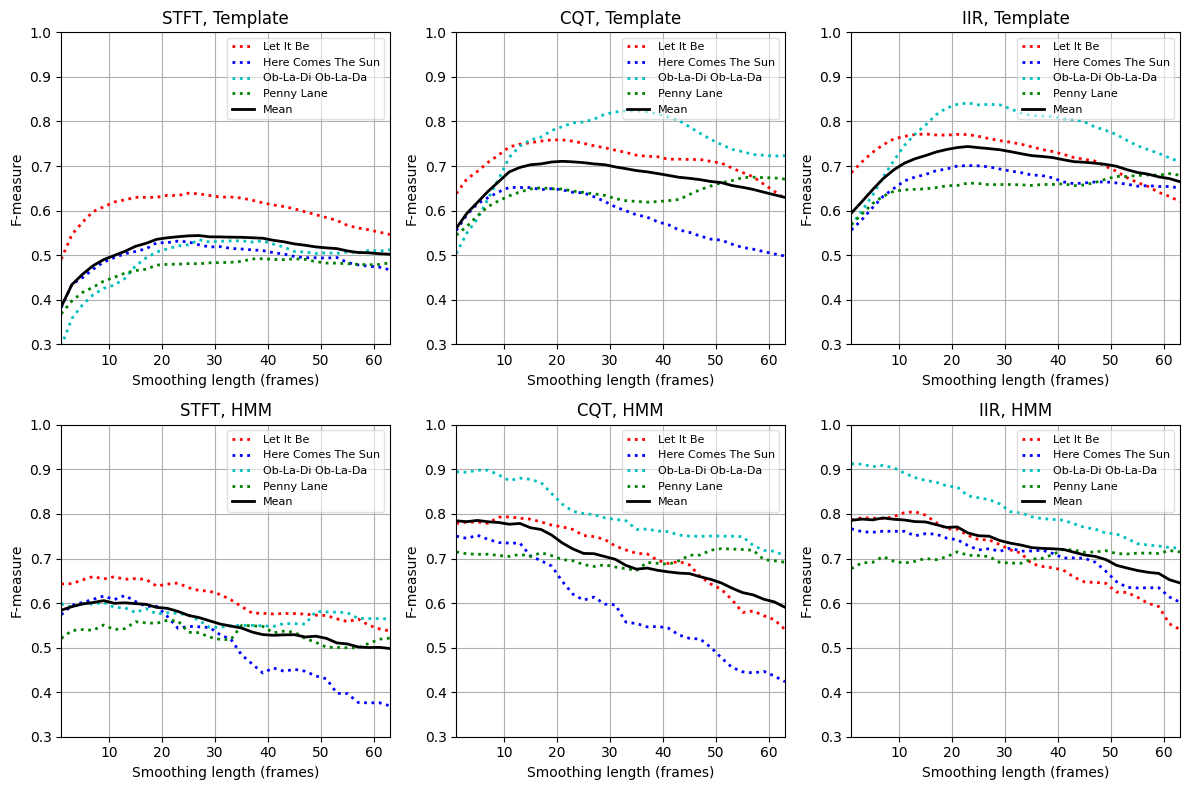

In [14]:
# Plot result
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
xlabel='Smoothing length (frames)'
ylim = [0.3, 1]
title='STFT, Template'
plot_statistics(para_list, song_dict, song_selected, result_STFT[0], ax[0, 0], 
                ylim=ylim, title=title, xlabel=xlabel)
title='STFT, HMM'
plot_statistics(para_list, song_dict, song_selected, result_STFT[1], ax[1, 0], 
                ylim=ylim, title=title, xlabel=xlabel)
title='CQT, Template'                           
plot_statistics(para_list, song_dict, song_selected, result_CQT[0], ax[0, 1], 
                ylim=ylim, title=title, xlabel=xlabel)
title='CQT, HMM'
plot_statistics(para_list, song_dict, song_selected, result_CQT[1], ax[1, 1], 
                ylim=ylim, title=title, xlabel=xlabel)
title='IIR, Template'                           
plot_statistics(para_list, song_dict, song_selected, result_IIR[0], ax[0, 2], 
                ylim=ylim, title=title, xlabel=xlabel)
title='IIR, HMM'
plot_statistics(para_list, song_dict, song_selected, result_IIR[1], ax[1, 2], 
                ylim=ylim, title=title, xlabel=xlabel)
plt.tight_layout()  

- STFT 경우와 **템플릿 기반 화음 인식기**에서 F-measure는 $L=1$에서 $\mathrm{F}=0.39$이다. $L$가 증가함에 따라 향상되고 $20$에서 $30$ 사이 $L$에 대해 대략 $\mathrm{F}=0.55$의 최대값에 도달한다. 그런 다음 $L$를 더 올리면 다시 감소한다. CQT 기반 및 IIR 기반 크로마그램을 사용할 때도 유사한 경향을 관찰할 수 있다.

- 모든 경우(`STFT`, `CQT`, `IIR`)에서 스무딩은 특징의 **시간 변동(temporal fluctuations) 및 로컬 이상값(local outliers)을 제거**하여 프레임별 분류 결과를 개선한다. 또한 스무딩은 음악적으로 동일한 화음에 속하는 **비동기 음(nonsynchronous notes)을 통합**할 수 있다.  반면에 스무딩은 **시간 해상도 (temporal resolution)를 감소**시키고 인식기가 짧은 듀레이션의 화음을 감지하지 못하게 할 수 있다.

- 비틀즈 노래의 경우 오디오의 약 1~2초에 해당하는 스무딩 윈도우는 이상값에 대한 견고성 증가와 시간 해상도 감소 사이에서 적절한 절충안으로 보인다. 그러나 이 trade-off는 실험에 사용된 기본 오디오 자료의 화음 변화 속도에 크게 의존한다.

- **HMM 기반 화음 인식기**의 경우 특징의 시간적 스무딩은 화음 인식 정확도에 덜 중요하거나 심지어 부정적인 영향을 미친다. 이미 분류 단계에서 일부 **사후 필터링(postfiltering)** 을 통합한다. 따라서 분류에 앞서 추가적인 평활화는 전체 인식 결과를 더 이상 개선하지 않는다.

## 자기 전이 확률 (Self-Transition Probability)

- HMM 기반 사후필터링의 맥락에서 [Cho and Bello](https://ieeeexplore.ieee.org/document/6691936)는 연구에서 **자기 전이 확률(self-transition probability)** 의 중요성을 강조했다.

- $\mathbf{C}$에서 $\mathbf{G}$로의 전환과 같이 음악적으로 두드러진 특정 전환의 강화(예: 으뜸음-딸림음 관계 표현)가 음악적으로 의미 있는 특정 화음의 증폭으로 이어질 수 있지만, 주요 개선은 기본적으로 화음 변경 횟수를 줄이는 **높은 자기 전이 확률**로부터 얻는다.

- **균일 전리 확률 행렬**을 사용할 수 있다. 이 행렬에서는 자기 전환을 제외하고 모든 전환에 동일한(상대적으로 작은) 확률 값이 할당된다. [Cho and Bello](https://ieeeexplore.ieee.org/document/6691936)의 연구에 따르면, 이 균일한 전이 확률 행렬을 사용하더라도 더 복잡한 전이 확률 행렬을 사용할 때와 유사한 개선을 얻을 수 있다.

- 균일 전리 확률 행렬을 정의하려면 주대각선으로 인코딩된 자기 전이에 사용되는 매개변수 $p\in[0,1]$를 지정해야 한다. 대각선이 아닌 확률은 다음과 같이 지정된다.
$$q = \frac{1-p}{I}$$
여기서 $I$는 HMM 상태(state)의 수이다(이 시나리오에서는 $I=24$임).

- 다음 코드 셀에서 자기-전이 매개변수 $p\in[0, 0.02, 0.04, \ldots, 0.98, 1]$의 스윕(sweep)을 고려하는 작은 실험을 제시한다.

- 관찰할 수 있듯이 $p\approx0.22$(STFT 기반 크로마그램 사용 시)에 대해 대략 $\mathrm{F}=0.60$, $p\approx0.18$(CQT 기반 및 IIR 기반 크로마그램 사용 시)에 대해 $\mathrm{F}=0.80$를 얻는다.

- $p$ 매개변수는 예상되는 화음 변화율과 관련된 속성을 반영하며, 이는 화음 주석들의 통계 및 사용된 feature rate에 크게 의존한다. 데이터 기반 기계 학습에서 자기 전환 매개변수는 독립적인 **validation set**를 사용하여 최적화할 수 있는 **hyperparameter**로 간주할 수 있다.

===== Self-transition probability experiment using STFT-based chromagrams =====
Processing: Let It Be
Processing: Here Comes The Sun
Processing: Ob-La-Di Ob-La-Da
Processing: Penny Lane

===== Self-transition probability experiment using CQT-based chromagrams =====
Processing: Let It Be
Processing: Here Comes The Sun
Processing: Ob-La-Di Ob-La-Da
Processing: Penny Lane

===== Self-transition probability experiment using IIR-based chromagrams =====
Processing: Let It Be
Processing: Here Comes The Sun
Processing: Ob-La-Di Ob-La-Da
Processing: Penny Lane



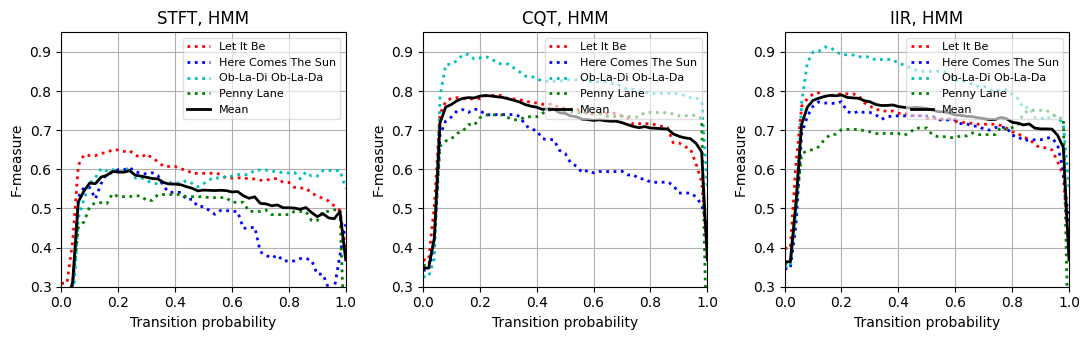

In [15]:
song_selected = [0, 1, 2, 3]
para_list = (np.arange(51)) * 0.02
print('===== Self-transition probability experiment using STFT-based chromagrams =====')
result_STFT = experiment_chord_recognition(song_selected, song_dict, X_dict_STFT, ann_dict_STFT, 
                                           para_list, para_type='p', p=0.15, filt_len=None)
print('===== Self-transition probability experiment using CQT-based chromagrams =====')
result_CQT  = experiment_chord_recognition(song_selected, song_dict, X_dict_CQT, ann_dict_CQT, 
                                           para_list, para_type='p', p=0.15, filt_len=None)
print('===== Self-transition probability experiment using IIR-based chromagrams =====')
result_IIR  = experiment_chord_recognition(song_selected, song_dict, X_dict_IIR, ann_dict_IIR, 
                                           para_list, para_type='p', p=0.15, filt_len=None)

# Plot result
fig, ax = plt.subplots(1,3, figsize=(11, 3.5))
xlabel='Transition probability'
ylim = [0.3, 0.95]
title='STFT, HMM'
plot_statistics(para_list, song_dict, song_selected, result_STFT[1], ax[0], ylim=ylim, title=title, xlabel=xlabel)
title='CQT, HMM'
plot_statistics(para_list, song_dict, song_selected, result_CQT[1], ax[1], ylim=ylim, title=title, xlabel=xlabel)
title='IIR, HMM'
plot_statistics(para_list, song_dict, song_selected, result_IIR[1], ax[2], ylim=ylim, title=title, xlabel=xlabel)
plt.tight_layout()  

# 음악적 관련성

## 클래스 불균형(Class Imbalance)

- 이전에 이미 언급했듯이 자동화된 화성 분석 및 참조 주석을 기반으로 한 평가는 일반적으로 상당히 단순화된다. 따라서 평가 측정(예: F-measure)은 알고리즘의 성능과 인식 결과의 음악적 관련성에 대해 매우 제한된 관점만 제공한다. 
- 구체적인 예로서 노래의 일부 전면적 통계를 기반으로 단일 장, 단3화음을 결정하고 모든 시간 프레임에 해당하는 화음 라벨을 출력하는 다소 **둔한 화음 인식기**를 고려해 보자.
    - 노래 "Ob-La-Di, Ob-La-Da"의 경우, 이 접근법은 노래의 키 $\mathrm{B}^\flat$ major를 인식하고 tonic 화음 $\mathrm{B}^\flat$에 대해 노래에 대한 동일한 화음 라벨을 전체 길이 동안 출력할 수 있다. 
    
- 다음 코드 셀에서 볼 수 있듯이 이 절차는 $\mathrm{F}=0.551$의 F-점수를 달성한다. 특히 CQT 기반 크로마그램을 사용하는 템플릿 기반 접근 방식이 $\mathrm{F}=0.503$의 정확도만 달성한다는 점을 고려할 때 이는 나쁘지 않은 것 같다.
    * 그렇다면 $\mathrm{F}=0.551$ 값은 무엇을 의미할까?
    * 이 단조로운 절차가 템플릿 기반 접근 방식보다 "더 나은" 것인가?

- 화음 라벨링 작업을 해결하는 대신, 이 단순한 인식기는 가장 흔한 화음 발생에 대한 해당 데이터의 통계에 대해 더 많은 정보를 알려준다.
- 일반적으로 평가 결과를 보다 잘 평가하기 위해서는 데이터 분포에 대한 정보를 포함하는 것이 중요하다.
- 특히 **클래스 분포의 불균형(imbalance)** 은 분류(classification) 접근 방식의 실제 성능에 대해서는 어떤 것도 이야기 할 수 없지만, 매우 높은 평가 측정이 나올 수 있다.

- 이 논의를 마무리하기 위해, HMM 기반 접근법이 $\mathrm{F}=0.895$의 F-측정값을 생성한다는 점에 주목하자. 이는 위의 단순한 접근법의 $\mathrm{F}=0.551$보다 훨씬 높다.
- 시각화에서 볼 수 있듯이(예: $1700$와 $2000$ 프레임 사이의 섹션 참조) HMM 기반 접근 방식은 템플릿 기반 접근 방식의 일부 오류를 수정한다. 여기서 메이저 화음 $\mathrm{E}^\flat$ (참조)는 마이너 화음 $\mathrm{E}^\flat\mathrm{m}$ (추정)과 혼동된다.
- 이러한 "장-단 화음 혼동"은 자동화된 절차에서 발생하는 가장 일반적인 인식 오류 중 하나이다.
    - 이러한 혼동은 두 개의 3화음이 3개 음 중 2개인 근음(root note)과 5도(fifth)를 공유한다는 사실에 기인한다. 일반적으로 조화 부분음의 존재로 인해 더 많은 혼란이 발생할 수 있다(예: 근음의 5번째 배음은 장3도와 같음).

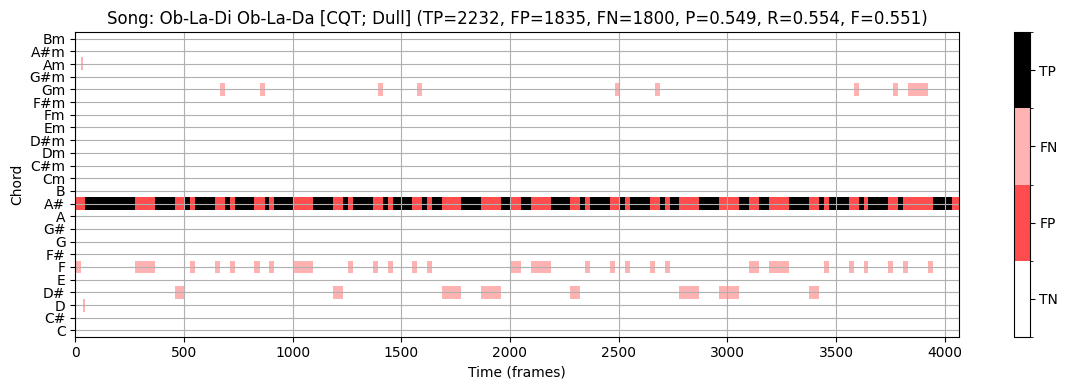

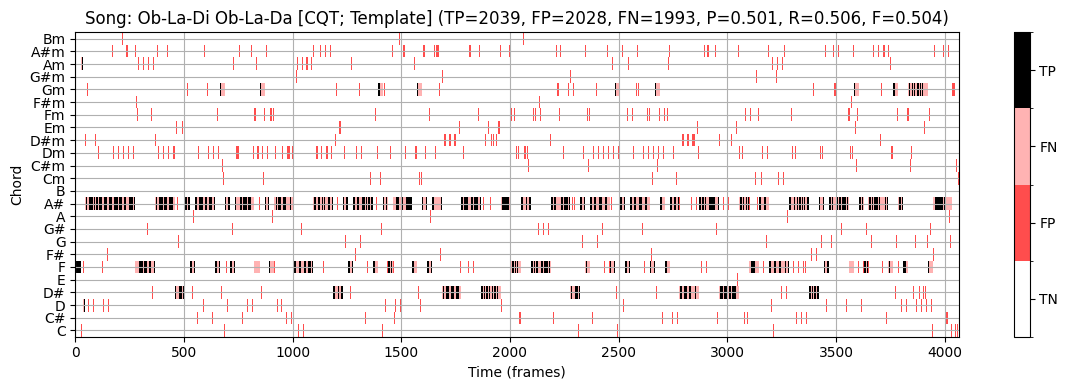

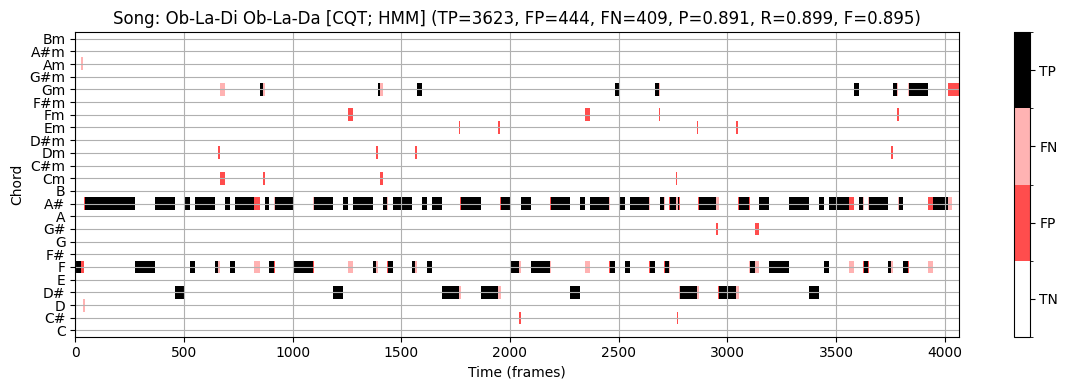

In [16]:
song_selected = [2]    
for s in song_selected:
    output = chord_recognition_all(X_dict_CQT[s], ann_dict_CQT[s][0], p=0.15)
    result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim = output
    chord_dull = np.zeros(chord_Tem.shape)
    chord_dull[10, :] = 1    
    result_dull = compute_eval_measures(ann_dict_CQT[s][0], chord_dull)    

    title='Song: %s [CQT; Dull]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_CQT[s][0], result_dull,
                                  chord_dull, chord_labels, title=title)
    title='Song: %s [CQT; Template]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_CQT[s][0], result_Tem, 
                                  chord_Tem, chord_labels, title=title)
    title='Song: %s [CQT; HMM]' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_CQT[s][0], result_HMM, 
                                  chord_HMM, chord_labels, title=title)

## 화음 라벨 감소

- 화음 인식 방식의 또 다른 주요 문제는 $12$ 장조 및 $12$ 단조 3화음에 해당하는 $24$ 화음 클래스로만 제한된다는 것이다.

- 보다 일반적인 설정을 설명하기 위해 참조 주석에 사용되는 다른 코드 유형(예: 7도, 증가(augmented) 및 감소(diminished) 화음)을 장조 및 단조 3화음으로 줄였다. 이하에서는 이 변환을 **트라이어드(=3화음) 축소 (triad reduction)** 라고 하자.

- 하나의 명백한 물음은 화음 인식 오류가 그러한 화음 유형 축소가 사용된 악절에서 더 자주 발생하는지 여부이다.

- 이 질문을 조사하기 위해 $24$ 장,단3화음에 포함되지 않은 화음 유형을 비화음(non-chord) 라벨 $\mathbf{N}$로 대체하는 두 번째 축소 표현을 고려해본다. 이하에서는 이 변환을 **비화음 축소(non-chord reduction)** 라고 하자.

- 예를 들어, 원래 참조 주석에서 이러한 추가 화음 유형이 많이 발생하는 노래 "Penny Lane"을 보자. 다음 그림에서 결과적인 3화음 축소와 비화음 축소(비화음 라벨 $\mathbf{N}$가 흰색으로 표시됨)를 보여준다.

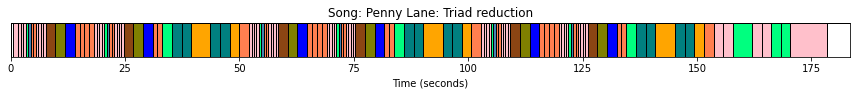

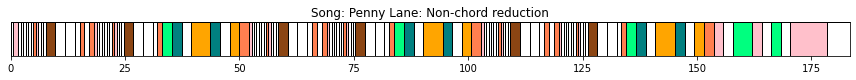

In [17]:
for s in [3]:
    song_id = song_dict[s][0]
    fn_ann = song_dict[s][3]
    fn_ann_orig = fn_ann.replace('_simplified', '')
    
    # Read original annotation (Harte) and triad-reduced annotation
    ann_orig, _ = read_structure_annotation(fn_ann_orig)
    ann, _ = read_structure_annotation(fn_ann)
    # Replace in original annotation all labels that were reducued by non-chord label 
    for k in range(len(ann)):
        if ann[k][2] != ann_orig[k][2]:
            ann_orig[k][2] = 'N'

    plot_segments(ann, figsize=(12, 1.2), time_label='Time (seconds)', 
                           print_labels=False, colors=color_ann, alpha=1)
    plt.title('Song: %s: Triad reduction' % song_id)    
    plt.show()
    plot_segments(ann_orig, figsize=(12, 1), 
                           print_labels=False, colors=color_ann, alpha=1)
    plt.title('Song: %s: Non-chord reduction' % song_id)
    plt.show()

- 다음으로, 3화음 축소에 기반한 참조 주석을 한 번 사용하고, 비화음 축소에 기반한 주석을 한 번 사용하여 HMM 기반 화음 인식 접근 방식을 평가해보자.

1. **아이템** $(n, \lambda)$는 세트 $\mathcal{I}=[1:N]\times \Lambda$의 요소이다. 이 규칙에서 화음이 아닌 라벨 $\mathbf{N}$는 고려되지 않은 상태로 남는다.
2. 결과적으로 **관련(relevant)**(또는 **양수**) 아이템은 $(n, \lambda^\mathrm{Ref}_{n})$와 $\lambda^\mathrm{Ref}_{n}\not=\mathbf{N}$의 쌍이다.
3. HMM 기반 화음 인식 접근 방식은 각 프레임 $n\in[1:N]$에 대한 추정 $\lambda_{n}\in\Lambda$를 생성하므로, 쌍 $(n,\lambda_{n})$는 참조 주석의 프레임이 $\lambda^\mathrm{Ref}_{n}=\mathbf{N}$인 경우 **false positive**으로 계산된다.

- 이를 염두에 두고 다음 그림에 표시된 화음 인식 결과를 살펴보자. 
    - **3화음 축소**에 기반한 참조 주석을 사용하여 precision $\mathrm{P}=0.704$, recall $\mathrm{R}=0.726$ 및 F-측정값 $\mathrm{F}=0.715$를 얻는다. 
    - **비화음 축소**에 기반한 참조 주석을 사용하여 $\mathrm{P}=0.485$, $\mathrm{R}=0.925$ 및 $\mathrm{F}=0.636$를 얻는다. 
    
- **recall의 증가**는 **축소된 화음 라벨에 대해 화음 인식 오류가 종종 발생**한다는 가설을 정확히 뒷받침한다. 
- **precision 감소**는 화음 인식기가 모든 프레임 $n\in[1:N]$에 대해 화음 라벨 $\lambda_n\in\Lambda$를 출력하기 때문이다. 
- 이 결과는 예를 들어 모든 $24$ 화음 라벨의 출력 확률이 특정 임계값 아래로 떨어지는 경우, 화음 인식기가 비화음의 라벨도 출력하도록 허용함으로써 개선될 수 있다.

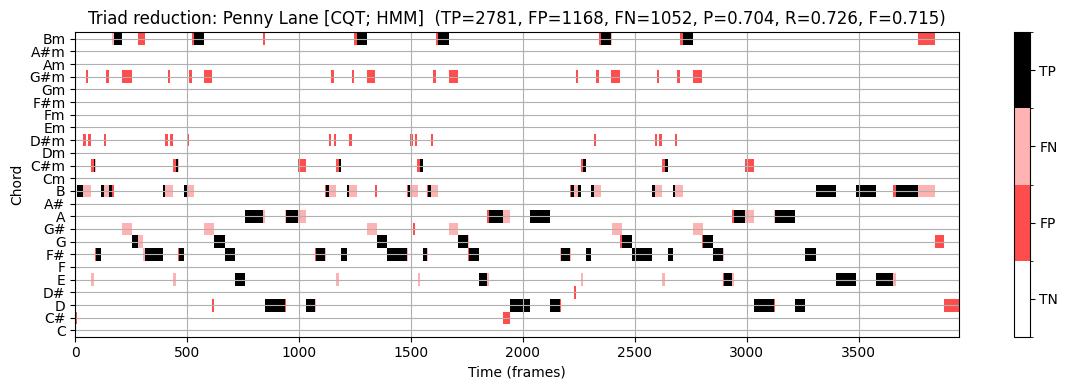

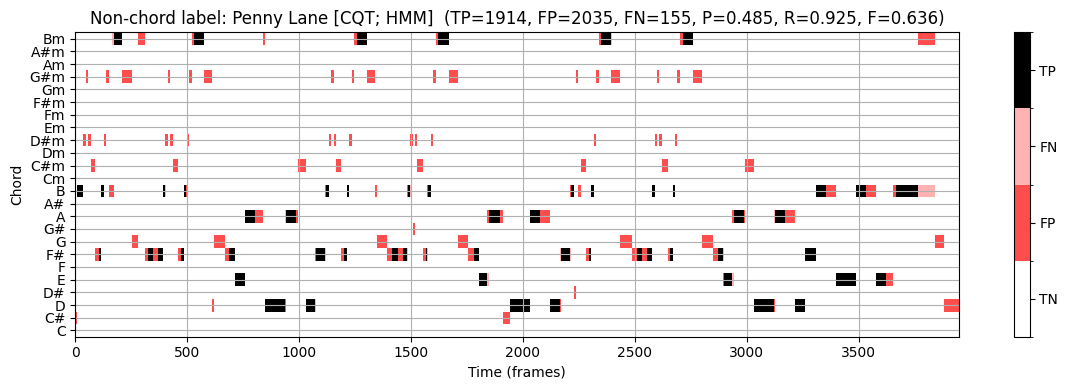

In [18]:
song_selected = [3] 
for s in song_selected:
    output = chord_recognition_all(X_dict_CQT[s], ann_dict_CQT[s][0], p=0.15)
    result_Tem, result_HMM, chord_Tem, chord_HMM, chord_sim = output
    song_id = song_dict[s][0]
    fn_ann = song_dict[s][3]
    fn_ann_orig = fn_ann.replace('_simplified', '')    
    ann_orig, _ = read_structure_annotation(fn_ann_orig)
    output =  convert_chord_ann_matrix(fn_ann_orig, chord_labels, Fs=Fs_X_dict_CQT[s],
                                                 N=X_dict_CQT[s].shape[1], last=False)    
    ann_matrix_N = output[0]    
    output = chord_recognition_all(X_dict_CQT[s], ann_matrix_N, p=0.15)
    result_Tem_N, result_HMM_N, chord_Tem_N, chord_HMM_N, chord_sim_N = output    
    title = 'Triad reduction: %s [CQT; HMM] ' % song_dict[s][0]
    plot_chord_recognition_result(ann_dict_CQT[s][0], result_HMM, chord_HMM, chord_labels, title=title)    
    title = 'Non-chord label: %s [CQT; HMM] ' % song_dict[s][0]
    plot_chord_recognition_result(ann_matrix_N, result_HMM_N, chord_HMM_N, chord_labels, title=title)

# 결론

* 요약하면, 시간적 피쳐 스무딩(temporal feature smoothing)은 순전히 프레임 별로 작동하는 화음 인식기의 전체 평가 측정을 개선하는 쉬운 방법이라고 말할 수 있다. 그러나 "최적" 스무딩 길이는 화음 지속 시간 분포에 따라 크게 달라진다.

* 고정 길이의 평균화 필터를 사용하는 대신, 음악적으로 정보를 얻은 적응형 세분화 기술(adaptive segmentation techniques)을 사용하는 것이 대안이다. 예를 들어 화음 변경은 종종 비트(beat) 위치와 함께 진행된다. 따라서 **beat-synchronous** 방식으로 필터링을 수행할 수 있다. 여기서 각 분석 창은 두 개의 연속 비트 위치에 의해 결정된다. 그러나 자동화된 방법으로 비트 위치를 찾는 것은 그 자체로 어려운 작업이기도 하다.

* 분류 단계 이전에 특징을 수정하는 대신 또 다른 일반적인 접근 방식은 HMM 기반 접근 방식과 정확히 일치하는 패턴 매칭 단계 내에서 일종의 필터링을 수행하는 것이다. **사후 필터링**(HMM 사용)과 **사전 필터링**(피처 스무딩 사용)의 조합이 전체 인식 결과를 크게 개선하지 않는다는 것을 확인했다.

* 비틀즈 컬렉션에는 중심 주파수가 $440~\mathrm{Hz}$인 예상 참고 피치 $\mathrm{A4}$에서 벗어난 곡들이 다수 있다. 이러한 편차는 화음 인식기에 대한 입력 역할을 하는 크로마그램의 품질에 치명적인 결과를 초래할 수 있다. 따라서 화음 인식 시스템에서 중요한 단계 중 하나는 튜닝 추정(tuning estimation)을 수행하여 튜닝 효과를 보상한 다음, 주파수 축의 피치 기반 로그 분할에 사용되는 중심 주파수를 조정하는 것이다.

* 비틀즈 컬렉션은 단 하나의 록 밴드로 제한되지만, 이 데이터 세트를 실험하는 것은 화음 인식 시스템을 개발하고 비교할 때 매우 유익할 수 있다. 특히 데이터 기반 기술(예: 최근 딥 러닝 기술)을 사용하는 경우 데이터 세트를 **훈련(training) 세트**, **검증(validation) 세트** 및 **테스트(test) 세트**라는 분리된 하위 집합으로 분할하는 것이 중요하다. 훈련 세트를 사용하여 화음 템플릿을 조정하거나 특정 HMM 매개변수를 학습할 수 있다. 검증 세트는 예를 들어 HMM 아키텍처를 결정하는 하이퍼파라미터를 조정하는 데 사용될 수 있다. 마지막으로 테스트 세트는 최종 시스템을 테스트하고 평가하는 데 사용한다.

* 데이터 세트 분할에 대한 전체 절차의 종속성을 줄이기 위해 종종 여러 라운드의 **교차 검증(cross-validation)** 을 수행한다. 한 가지 방법은 데이터 세트를 동일한 크기의 $K$ 하위 집합(소위 **fold**)으로 임의로 분할하는 것이다. 하위 집합 중 하나는 테스트 집합으로 사용되는 반면 다른 $K-1$ 하위 집합의 합집합은 훈련 및 검증 집합으로 사용된다. 교차 검증은 테스트 세트로 정확히 한 번 제공되는 각 $K$ 하위 집합으로 $K$ 번 반복된다. 그런 다음 $K$ 결과는 예를 들어 고려된 평가 척도의 평균을 취하여 결합되어 단일 추정치를 형성한다. 일반적으로 **$K$-fold 교차 검증** 으로 알려진 이 접근 방식은 일종의 훈련이 포함된 화음 인식 절차를 평가하는 데 자주 사용된다.

---

출처: 

- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S3_ChordRec_Beatles.html
---

[구글 Colab 링크](https://colab.research.google.com/github/jo-cho/mir_kr/blob/main/Notebooks/6.%20Chord%20Recognition/6.4.Chord_Recognition_with_the_Beatles_Example.ipynb)